# Inverse design optimization of a mode converter

> Note: native autograd support is an experimental feature in tidy3d 2.7. To see the original implementation of this notebook using jax and the adjoint plugin, refer to [this notebook](https://www.flexcompute.com/tidy3d/examples/notebooks/AdjointPlugin3InverseDesign/).

In this notebook, we will use inverse design and Tidy3D to create an integrated photonics component to convert a fundamental waveguide mode to a higher order mode.

In [1]:
from typing import List
import numpy as np
import matplotlib.pylab as plt

import autograd.numpy as anp
from autograd import value_and_grad

# import regular tidy3d
import tidy3d as td
import tidy3d.web as web
from tidy3d.plugins.mode import ModeSolver

# set random seed to get same results
np.random.seed(2)

## Setup

We wish to recreate a device like the diagram below:

<img src="img/AdjointInvDes.png" width=800 alt="Schematic of the mode converter">

A mode source is injected into a waveguide on the left-hand side. The light propagates through a rectangular region with pixellated permittivity with the value of each pixel independently tunable between 1 (vacuum) and some maximum permittivity. Finally, we measure the transmission of the light into a waveguide on the right-hand side.

The goal of the inverse design exercise is to find the best distribution of permittivities ($\epsilon_{ij}$) in the coupling region to maximize the power conversion between the input mode and the output mode.

We also apply our built-in smoothening and binarization filters to ensure that the final device has smooth features, and permitivitty values that are all either 1, or the maximum permittivity of the waveguide material.

### Parameters

First we will define some parameters. 

In [2]:
# wavelength and frequency
wavelength = 1.0
freq0 = td.C_0 / wavelength
k0 = 2 * np.pi * freq0 / td.C_0

# resolution control
min_steps_per_wvl = 16
# in the design region, we set uniform grid resolution,
# and define the design parameters on the same grid
dl_design_region = 0.01

# space between boxes and PML
buffer = 1.0 * wavelength

# optimize region size
lz = td.inf
lx = 5.0
ly = 3.0

# position of source and monitor (constant for all)
source_x = -lx / 2 - buffer * 0.8
meas_x = lx / 2 + buffer * 0.8

# total size
Lx = lx + 2 * buffer
Ly = ly + 2 * buffer
Lz = 0.0

# permittivity and width of the input/output waveguide
eps_wg = 2.75
wg_width = 0.7

# random starting parameters between 0 and 1
nx = int(lx / dl_design_region)
ny = int(ly / dl_design_region)
params0 = np.random.random((nx, ny))

# frequency width and run time
freqw = freq0 / 10
run_time = 50 / freqw

### Static Components

Next, we will set up the static parts of the geometry, the input source, and the output monitor using these parameters.

In [3]:
waveguide = td.Structure(
    geometry=td.Box(size=(2 * Lx, wg_width, lz)), medium=td.Medium(permittivity=eps_wg)
)

mode_size = (0, wg_width * 3, lz)

source_plane = td.Box(
    center=[source_x, 0, 0],
    size=mode_size,
)

measure_plane = td.Box(
    center=[meas_x, 0, 0],
    size=mode_size,
)

### Input Structures

Next, we write a function to return the pixellated array given our flattened tuple of permittivity values $\epsilon_{ij}$ using the `tidy3d.plugins.autograd` plugin.

We start with an array of parameters between 0 and 1, apply a conic filter and tanh projection to compute smooth, well-binarized features.

In [4]:
from tidy3d.plugins.autograd.functions import rescale
from tidy3d.plugins.autograd.invdes import make_filter_and_project, get_kernel_size_px

# radius of the circular filter (um) and the threshold strength
radius = 0.120
beta = 50

filter_size = get_kernel_size_px(radius, lx / nx)
filter_project = make_filter_and_project(filter_size)


def get_eps(params, beta):
    """Get the permittivity values (1, eps_wg) array as a function of the parameters (0, 1)"""
    processed_params = filter_project(params, beta)
    eps = rescale(processed_params, 1, eps_wg)
    return eps


def make_input_structures(params, beta) -> List[td.Structure]:
    x0_min = -lx / 2 + dl_design_region / 2
    y0_min = -ly / 2 + dl_design_region / 2

    coords_x = [x0_min + dl_design_region * ix for ix in range(nx)]
    coords_y = [y0_min + dl_design_region * iy for iy in range(ny)]

    coords = dict(x=coords_x, y=coords_y, z=[0])

    eps = get_eps(params, beta=beta).reshape((nx, ny, 1))
    permittivity = td.SpatialDataArray(eps, coords=coords)
    custom_medium = td.CustomMedium(permittivity=permittivity)
    box = td.Box(center=(0, 0, 0), size=(lx, ly, lz))
    custom_structure = td.Structure(geometry=box, medium=custom_medium)

    return [custom_structure]

### Making the Simulation
Next, we write a function to return a basic `td.Simulation` as a function of our parameter values.

We make sure to add the pixellated `td.Structure` list to `input_structures` but leave out the sources and monitors for now as we'll want to add those after the mode solver is run so we can inspect them.

In [5]:
def make_sim_base(params: np.ndarray, beta: float) -> td.Simulation:
    """Create the simulation given the parameters and some beta value."""
    
    structures = make_input_structures(params, beta=beta)
    design_region_mesh = td.MeshOverrideStructure(
        geometry=td.Box(size=(lx, ly, lz)),
        dl=[dl_design_region] * 3,
        enforce=True,
    )
    grid_spec = td.GridSpec.auto(
        wavelength=wavelength,
        min_steps_per_wvl=16,
        override_structures=[design_region_mesh],
    )

    return td.Simulation(
        size=[Lx, Ly, Lz],
        grid_spec=grid_spec,
        structures=[waveguide] + structures,
        sources=[],
        monitors=[],
        run_time=run_time,
        boundary_spec=td.BoundarySpec.pml(x=True, y=True, z=False),
    )

### Visualize
Let's visualize the simulation to see how it looks

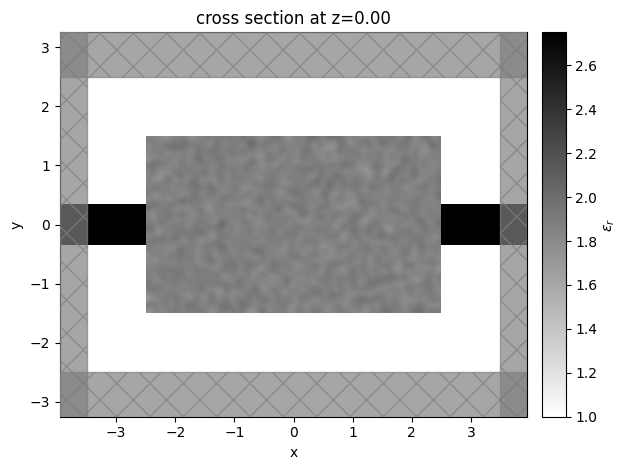

In [6]:
sim_start = make_sim_base(params0, beta=1.0)

ax = sim_start.plot_eps(z=0)

plt.show()

### Select Input and Output Modes

Next, let's visualize the first 4 mode profiles so we can select which mode indices we want to inject and transmit.

In [7]:
from tidy3d.plugins.mode.web import run as run_mode_solver

num_modes = 4
mode_spec = td.ModeSpec(num_modes=num_modes)

mode_solver = ModeSolver(
    simulation=sim_start,
    plane=source_plane,
    mode_spec=td.ModeSpec(num_modes=num_modes),
    freqs=[freq0],
)
modes = run_mode_solver(mode_solver, reduce_simulation=True)

15:02:19 EDT Mode solver created with                                           
             task_id='fdve-1fb55c64-b495-4303-895a-22ba16383542',               
             solver_id='mo-89df1e39-c7e4-4c2b-a1bc-ef20884a45e2'.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/
rich/live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

15:02:22 EDT Mode solver status: queued

15:02:24 EDT Mode solver status: running

15:02:29 EDT Mode solver status: success

Let's visualize the modes next.

Effective index of computed modes:  [[1.5720801 1.535463  1.3032305 1.1848158]]


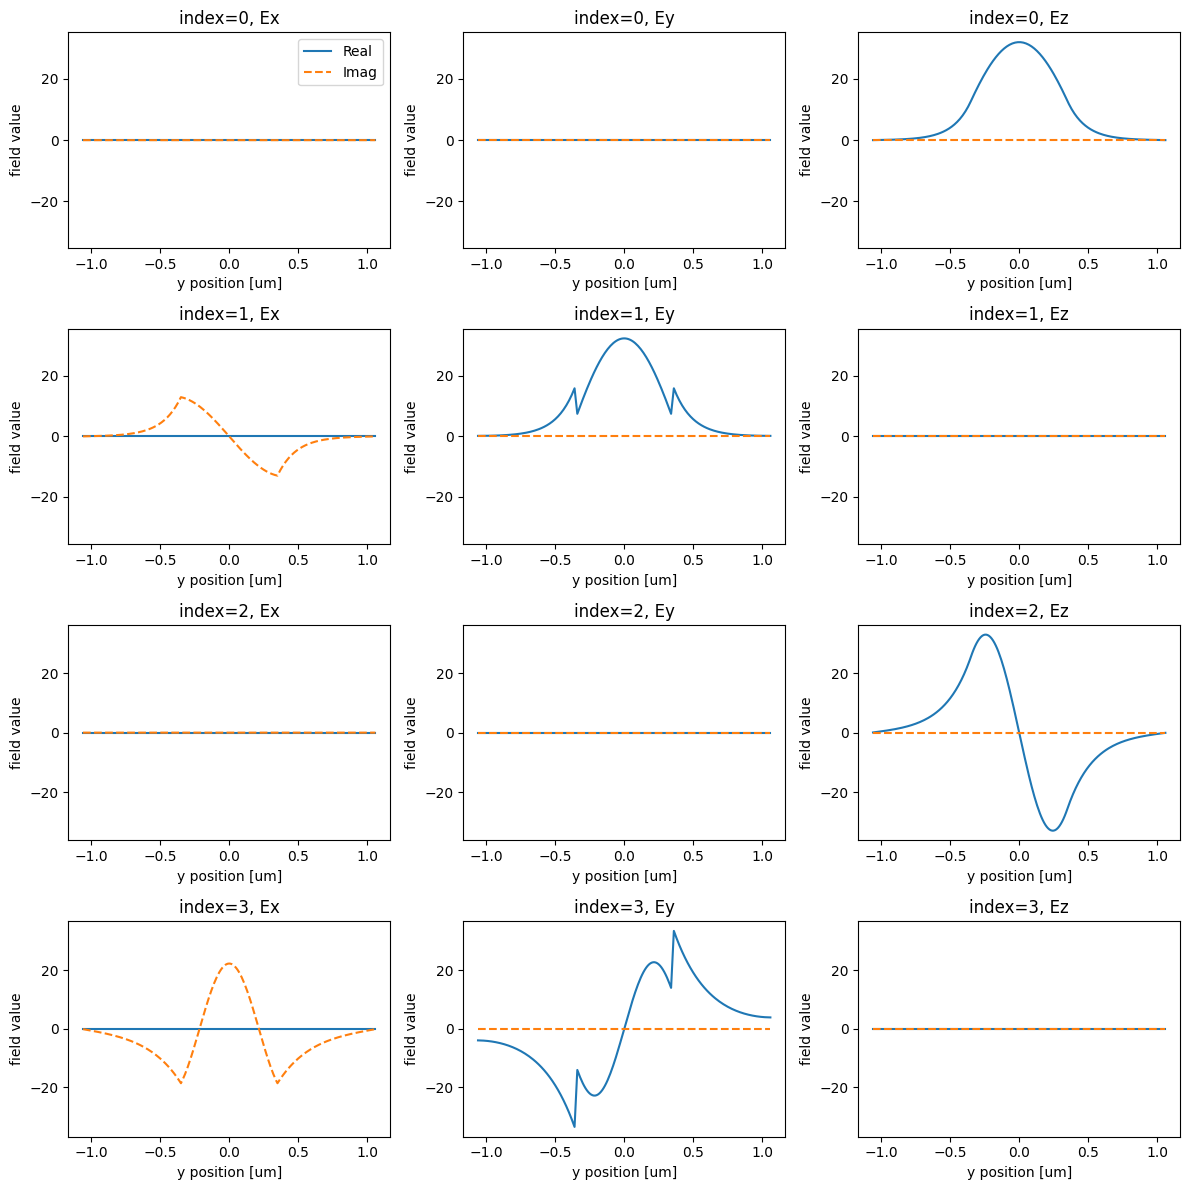

In [8]:
fig, axs = plt.subplots(num_modes, 3, figsize=(12, 12), tight_layout=True)
for mode_index in range(num_modes):
    vmax = 1.1 * max(
        abs(modes.field_components[n].sel(mode_index=mode_index)).max() for n in ("Ex", "Ey", "Ez")
    )
    for field_name, ax in zip(("Ex", "Ey", "Ez"), axs[mode_index]):
        field = modes.field_components[field_name].sel(mode_index=mode_index)
        field.real.plot(label="Real", ax=ax)
        field.imag.plot(ls="--", label="Imag", ax=ax)
        ax.set_title(f"index={mode_index}, {field_name}")
        ax.set_ylim(-vmax, vmax)

axs[0, 0].legend()

print("Effective index of computed modes: ", np.array(modes.n_eff))

We want to inject the fundamental, Ez-polarized input into the 1st order Ez-polarized input.

From the plots, we see that these modes correspond to the first and third rows, or `mode_index=0` and `mode_index=2`, respectively. 

So we make sure that the `mode_index_in` and `mode_index_out` variables are set appropriately and we set a `ModeSpec` with 3 modes to be able to capture the `mode_index_out` in our output data.

In [9]:
mode_index_in = 0
mode_index_out = 2

num_modes = max(mode_index_in, mode_index_out) + 1

mode_spec = td.ModeSpec(num_modes=num_modes)

Then it is straightforward to generate our source and monitor.

In [10]:
# source seeding the simulation
forward_source = td.ModeSource(
    source_time=td.GaussianPulse(freq0=freq0, fwidth=freqw),
    center=[source_x, 0, 0],
    size=mode_size,
    mode_index=mode_index_in,
    mode_spec=mode_spec,
    direction="+",
)

# we'll refer to the measurement monitor by this name often
measurement_monitor_name = "measurement"

# monitor where we compute the objective function from
measurement_monitor = td.ModeMonitor(
    center=[meas_x, 0, 0],
    size=mode_size,
    freqs=[freq0],
    mode_spec=mode_spec,
    name=measurement_monitor_name,
)

Finally, we create a new function that calls our `make_sim_base()` function and adds the source and monitor to the result. This is the function we will use in our objective function to generate our `td.Simulation` given the input parameters.

In [11]:
def make_sim(params, beta):
    sim = make_sim_base(params, beta=beta)
    return sim.updated_copy(sources=[forward_source], monitors=[measurement_monitor])

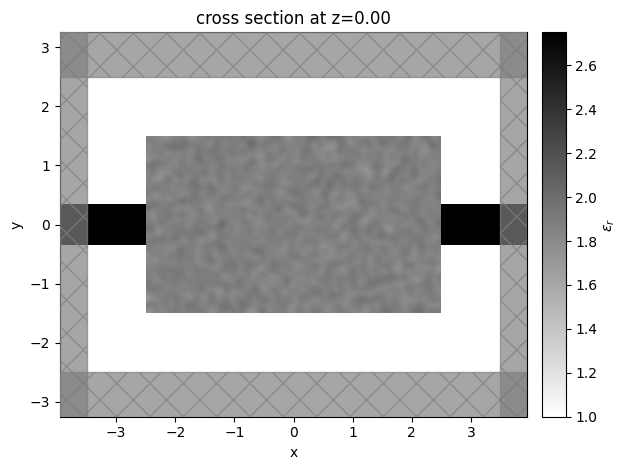

In [12]:
sim_start = make_sim_base(params0, beta=1.0)

ax = sim_start.plot_eps(z=0)

plt.show()

### Post Processing

Next, we will define a function to tell us how we want to postprocess the output `td.SimulationData` object to give the conversion power that we are interested in maximizing.

In [13]:
def measure_power(sim_data: td.SimulationData) -> float:
    """Return the power in the output_data amplitude at the mode index of interest."""
    output_amps = sim_data["measurement"].amps
    amp = output_amps.sel(direction="+", f=freq0, mode_index=mode_index_out).values
    return anp.sum(anp.abs(amp) ** 2)

Then, we add a penalty to produce structures that are invariant under erosion and dilation, which is a useful approach to implementing minimum length scale features.

In [14]:
from tidy3d.plugins.autograd.invdes import make_erosion_dilation_penalty

penalty = make_erosion_dilation_penalty(filter_size)

### Define Objective Function

Finally, we need to define the objective function that we want to maximize as a function of our input parameters (permittivity of each pixel) that returns the conversion power. This is the function we will differentiate later.

In [15]:
def J(params: np.ndarray, beta: float, step_num: int = None, verbose: bool = False) -> float:
    sim = make_sim(params, beta=beta)
    task_name = "inv_des"
    if step_num:
        task_name += f"_step_{step_num}"
    sim_data = web.run(sim, task_name=task_name, verbose=verbose)
    penalty_weight = np.minimum(1, beta / 25)
    return measure_power(sim_data) - penalty_weight * penalty(params, beta)

## Inverse Design

Now we are ready to perform the optimization.

We use the `autograd.value_and_grad` function to get the gradient of `J` with respect to the permittivity of each `Box`, while also returning the converted power associated with the current iteration, so we can record this value for later.

Let's try running this function once to make sure it works.

In [16]:
dJ_fn = value_and_grad(J)

In [17]:
val, grad = dJ_fn(params0, beta=1, verbose=True)
print(grad.shape)

15:02:32 EDT Created task 'inv_des' with task_id                                
             'fdve-11ce806e-7427-4e23-afee-073fa25d3479' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=716538;https://tidy3d.simulation.cloud/workbench?taskId=fdve-11ce806e-7427-4e23-afee-073fa25d3479\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=581136;https://tidy3d.simulation.cloud/workbench?taskId=fdve-11ce806e-7427-4e23-afee-073fa25d3479\taskId]8;;\]8;id=716538;https://tidy3d.simulation.cloud/workbench?taskId=fdve-11ce806e-7427-4e23-afee-073fa25d3479\=]8;;\]8;id=242533;https://tidy3d.simulation.cloud/workbench?taskId=fdve-11ce806e-7427-4e23-afee-073fa25d3479\fdve]8;;\]8;id=716538;https://tidy3d.simulation.cloud/workbench?taskId=fdve-11ce806e-7427-4e23-afee-073fa25d3479\-11ce806e-742]8;;\
             ]8;id=716538;https://tidy3d.simulation.cloud/workbench?taskId=fdve-11ce806e-7427-4e23-afee-073fa25d3479\7-4e23-afee-073fa25d3479']8;;\.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/
rich/live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

15:02:36 EDT status = success

15:02:42 EDT loading simulation from simulation_data.hdf5

             Created task 'inv_des_adjoint' with task_id                        
             'fdve-5877bd7b-e75f-4d2e-9351-c80f373f2d4b' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=373873;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5877bd7b-e75f-4d2e-9351-c80f373f2d4b\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=210598;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5877bd7b-e75f-4d2e-9351-c80f373f2d4b\taskId]8;;\]8;id=373873;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5877bd7b-e75f-4d2e-9351-c80f373f2d4b\=]8;;\]8;id=430349;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5877bd7b-e75f-4d2e-9351-c80f373f2d4b\fdve]8;;\]8;id=373873;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5877bd7b-e75f-4d2e-9351-c80f373f2d4b\-5877bd7b-e75]8;;\
             ]8;id=373873;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5877bd7b-e75f-4d2e-9351-c80f373f2d4b\f-4d2e-9351-c80f373f2d4b']8;;\.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/
rich/live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

15:02:47 EDT status = success

15:02:52 EDT loading simulation from simulation_data.hdf5

(500, 300)


In [18]:
print(grad)

[[ 6.96357847e-09  1.38148602e-08  1.35479312e-08 ... -4.39162456e-09
  -4.54118692e-09 -2.30241108e-09]
 [ 1.41709681e-08  2.81195398e-08  2.75574260e-08 ... -8.79540650e-09
  -9.12358527e-09 -4.62745182e-09]
 [ 1.49667621e-08  2.96808764e-08  2.90269691e-08 ... -8.90673026e-09
  -9.32266931e-09 -4.74089058e-09]
 ...
 [ 3.53735136e-07  7.10053883e-07  7.18210785e-07 ... -6.70875701e-07
  -6.60518797e-07 -3.28573199e-07]
 [ 3.52523249e-07  7.07661240e-07  7.15908559e-07 ... -6.64681250e-07
  -6.54227525e-07 -3.25405256e-07]
 [ 1.76120196e-07  3.53520400e-07  3.57663349e-07 ... -3.31353919e-07
  -3.26103429e-07 -1.62202573e-07]]


### Optimization

We will use "Adam" optimization strategy to perform sequential updates of each of the permittivity values in the `td.CustomMedium`.

For more information on what we use to implement this method, see [this article](https://optimization.cbe.cornell.edu/index.php?title=Adam).

We will run 10 steps and measure both the permittivities and powers at each iteration.

We capture this process in an `optimize` function, which accepts various parameters that we can tweak.

In [19]:
import optax

# hyperparameters
num_steps = 20
learning_rate = 1.0

# initialize adam optimizer with starting parameters
params = np.array(params0)
optimizer = optax.adam(learning_rate=learning_rate)
opt_state = optimizer.init(params)

# store history
Js = []
params_history = [params]
beta_history = []

# gradually increase the binarization strength
beta0 = 1
beta_increment = 1

for i in range(num_steps):
    # compute gradient and current objective funciton value

    beta = beta0 + i * beta_increment
    value, gradient = dJ_fn(np.array(params), step_num=i + 1, beta=beta)

    # outputs
    print(f"step = {i + 1}")
    print(f"\tbeta = {beta:.4e}")
    print(f"\tJ = {value:.4e}")
    print(f"\tgrad_norm = {np.linalg.norm(gradient):.4e}")

    # compute and apply updates to the optimizer based on gradient (-1 sign to maximize obj_fn)
    updates, opt_state = optimizer.update(-gradient, opt_state, params)
    params = optax.apply_updates(params, updates)

    # cap the parameters
    params = anp.clip(params, 0.0, 1.0)

    # save history
    Js.append(value)
    params_history.append(params)
    beta_history.append(beta)

power = J(params_history[-1], beta=beta)
Js.append(power)

step = 1
	beta = 1.0000e+00
	J = -6.2616e-04
	grad_norm = 4.6131e-04
step = 2
	beta = 2.0000e+00
	J = 4.8414e-02
	grad_norm = 1.0094e-02
step = 3
	beta = 3.0000e+00
	J = 5.1679e-03
	grad_norm = 7.5015e-03
step = 4
	beta = 4.0000e+00
	J = -6.3260e-03
	grad_norm = 6.0253e-03
step = 5
	beta = 5.0000e+00
	J = 2.0562e-01
	grad_norm = 1.3835e-02
step = 6
	beta = 6.0000e+00
	J = 3.6581e-01
	grad_norm = 1.8684e-02
step = 7
	beta = 7.0000e+00
	J = 5.2511e-01
	grad_norm = 2.2134e-02
step = 8
	beta = 8.0000e+00
	J = 6.7889e-01
	grad_norm = 1.3829e-02
step = 9
	beta = 9.0000e+00
	J = 7.6641e-01
	grad_norm = 1.2396e-02
step = 10
	beta = 1.0000e+01
	J = 8.0840e-01
	grad_norm = 1.1019e-02
step = 11
	beta = 1.1000e+01
	J = 8.5199e-01
	grad_norm = 7.5821e-03
step = 12
	beta = 1.2000e+01
	J = 8.6904e-01
	grad_norm = 7.9270e-03
step = 13
	beta = 1.3000e+01
	J = 8.7933e-01
	grad_norm = 7.3986e-03
step = 14
	beta = 1.4000e+01
	J = 8.8451e-01
	grad_norm = 7.3838e-03
step = 15
	beta = 1.5000e+01
	J = 8.8899e

In [20]:
params_final = params_history[-1]

Let's run the optimize function.

and then record the final power value (including the last iteration's parameter updates).

### Results

First, we plot the objective function (power converted to 1st order mode) as a function of step and notice that it converges nicely!

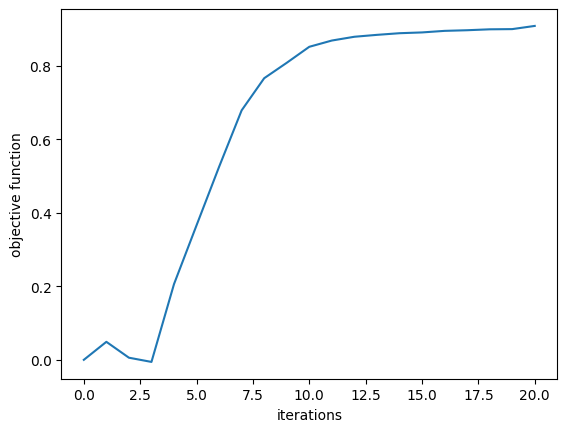

In [21]:
plt.plot(Js)
plt.xlabel("iterations")
plt.ylabel("objective function")
plt.show()

We then will visualize the final structure, so we convert it to a regular `Simulation` using the final permittivity values and plot it.

In [22]:
sim_final = make_sim(params_final, beta=beta)

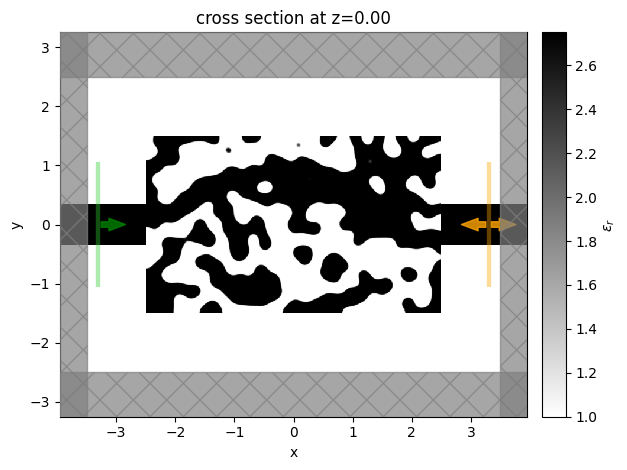

In [23]:
sim_final.plot_eps(z=0)
plt.show()

Finally, we want to inspect the fields, so we add a field monitor to the `Simulation` and perform one more run to record the field values for plotting.

In [24]:
field_mnt = td.FieldMonitor(
    size=(td.inf, td.inf, 0),
    freqs=[freq0],
    name="field_mnt",
)

sim_final = sim_final.copy(update=dict(monitors=(field_mnt, measurement_monitor)))

In [25]:
sim_data_final = web.run(sim_final, task_name="inv_des_final")

↓ simulation_data.hdf5.gz ━━━━━━━━━━━━ 100.0% • 10.3/10.3   • 6.7 MB/s • 0:00:00
                                                MB         

15:08:39 EDT loading simulation from simulation_data.hdf5

We notice that the behavior is as expected and the device performs exactly how we intended!

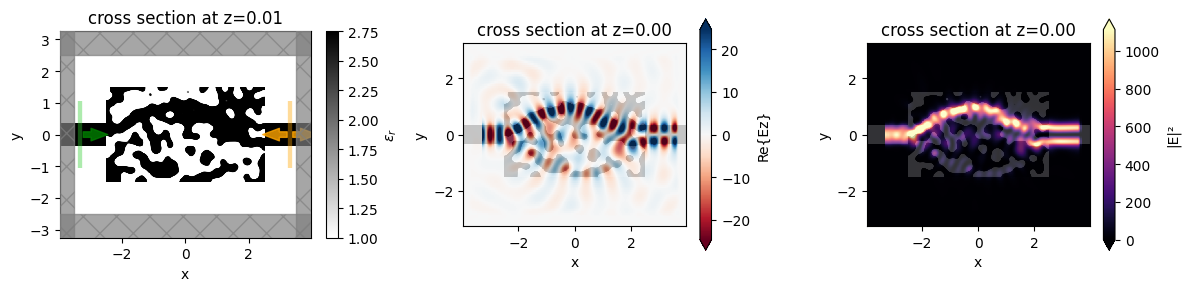

In [26]:
f, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(12, 3), tight_layout=True)
sim_final.plot_eps(z=0.01, ax=ax0)
ax1 = sim_data_final.plot_field("field_mnt", "Ez", z=0, ax=ax1)
ax2 = sim_data_final.plot_field("field_mnt", "E", "abs^2", z=0, ax=ax2)

The final device converts more than 90% of the input power to the 1st mode, up from < 1% when we started.

In [27]:
final_power = (
    sim_data_final["measurement"].amps.sel(direction="+", f=freq0, mode_index=mode_index_out).abs
    ** 2
)
print(f"Final power conversion = {final_power*100:.2f}%")

Final power conversion = 97.17%


## Export to GDS
The `Simulation` object has the [.to_gds_file](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.Simulation.html#tidy3d.Simulation.to_gds_file) convenience function to export the final design to a `GDS` file. In addition to a file name, it is necessary to set a cross-sectional plane (`z = 0` in this case) on which to evaluate the geometry, a `frequency` to evaluate the permittivity, and a `permittivity_threshold` to define the shape boundaries in custom mediums. See the [GDS export](https://www.flexcompute.com/tidy3d/examples/notebooks/GDSExport/) notebook for a detailed example on using `.to_gds_file` and other GDS related functions.

In [28]:
sim_final.to_gds_file(
    fname="./misc/inv_des_mode_conv.gds", z=0, frequency=freq0, permittivity_threshold=2.6
)